# Career path

Mapping career paths at TRANSFORM 2020.

We'll use a 'vocab' so that everyone uses more or less the same words... we'll do some fuzzy matching so we don't end up with 'undergrad' and 'undergraduate' as separate things.

In [1]:
# Apart from academic, it's mostly 'where you work', not 'what you do'.
VOCAB = ["student", "undergrad", "postgrad", "postdoc", "lecturer", "professor", "reader", "academic",
         "megaservice", "service", "microservice",
         "consultant", "sales",
         "software", "technology",
         "noc", "ioc", "independent", "exploration", "e&p",
         "government", "agency", "localgov",
         "mining",
         "unemployed", "self-employed", "retired",
         "startup",
         "other", # Relevant professional but doesn't fit elsewhere
         'break'  # Non-professional career break or other gap
        ]

Some made up data, including probably 'variants' (missing numbers, misspellings, no spaces, etc.).

The format is 'job' followed by a space then a number representing the number of years there. The records are separated by commas.

In [2]:
import difflib
m = difflib.get_close_matches('govt', VOCAB, n=1, cutoff=0.8)

In [4]:
data = [
    "undergraduate 3, postgraduate 4, noc 3, software 4, consultant 1, ioc 5, microservice 10",
    "undergrd 4, independent 5, startup 5, software 3",
    "undergrad 3, service 3, postgrad 5, postdoc 3, ioc 5, professor 16, retired",
    "undergrad 3, postgrad, postdoc 3, noc 4, professor 20, retired",
    "undergrad 3, megaservice 5, software 3, unemployed 1, exploration 3, startup 1",
    "undergrad 3,postgrad 2,postgrad 4,software 3,unemployed 1,exploration 3,startup 1",
    "undergrad, postgrad, government,  mining, self-employed,",
    "ioc 5, ioc 4, ioc 5",
]

## Parse data

In [9]:
import difflib
from datetime import datetime
from collections import defaultdict

def store_entry(data):
    """
    In the webapp, we'll record every single response 'raw' so we can process later.
    """
    with open('log.txt', 'ta') as f:
        d = datetime.utcnow().isoformat() + '\t'
        f.write(d + data + '\n')
    return 'Done'

def get_info(record):
    """
    Take a single response and turn it into a list of careers.
    
    Completely ignore the numbers for now.
    """
    items = [tuple(i.strip().split()) for i in record.split(',')]
    items = filter(None, items)
    path, years = [], defaultdict(int)
    for pair in items:
        # Get employment.
        m = difflib.get_close_matches(pair[0], VOCAB, n=1, cutoff=0.5)
        if m:
            path.append(m[0])
        else:
            path.append('other')

        # Get years.
        try:
            y = float(pair[1])
        except ValueError:  # Garbled number
            y = 1
        except IndexError:  # None provided
            y = 1
        years[m[0]] += y

    return path, years

In [10]:
# Just for the toy data.
paths, yearses = [], []
for record in data:
    store_entry(record)
    path, years = get_info(record)
    paths.append(path)
    yearses.append(years)

In [11]:
yearses

[defaultdict(int,
             {'undergrad': 3.0,
              'postgrad': 4.0,
              'noc': 3.0,
              'software': 4.0,
              'consultant': 1.0,
              'ioc': 5.0,
              'microservice': 10.0}),
 defaultdict(int,
             {'undergrad': 4.0,
              'independent': 5.0,
              'startup': 5.0,
              'software': 3.0}),
 defaultdict(int,
             {'undergrad': 3.0,
              'service': 3.0,
              'postgrad': 5.0,
              'postdoc': 3.0,
              'ioc': 5.0,
              'professor': 16.0,
              'retired': 1}),
 defaultdict(int,
             {'undergrad': 3.0,
              'postgrad': 1,
              'postdoc': 3.0,
              'noc': 4.0,
              'professor': 20.0,
              'retired': 1}),
 defaultdict(int,
             {'undergrad': 3.0,
              'megaservice': 5.0,
              'software': 3.0,
              'unemployed': 1.0,
              'exploration': 3.0,
        

In [12]:

years, sum(years.values())

(defaultdict(int, {'ioc': 14.0}), 14.0)

Use a Shelf:

In [13]:
!rm edges.*

In [14]:
!rm nodes.*

In [15]:
!rm lens.*

In [16]:
!rm lasts.*

In [17]:
import shelve
from collections import Counter

def store(path, years):
    with shelve.open('edges') as db:
        for pair in [*zip(path[:-1], path[1:])]:
            count = db.get(','.join(pair), 0)
            db[','.join(pair)] = count + 1
    with shelve.open('nodes') as db:
        for k, v in years.items():
            vi = db.get(k, 0)
            db[k] = vi + v
    with shelve.open('lasts') as db:
        last = path[-1]
        db[last] = db.get(last, 0) + 1
    with shelve.open('lens') as db:
        length = str(int(sum(years.values())))
        db[length] = db.get(length, 0) + 1
    return

In [18]:
for path, years in zip(paths, yearses):
    store(path, years)

## Make network

In [19]:
import networkx as nx

G = nx.Graph()

# nx.set_node_attributes(G, d, name='count')

with shelve.open('nodes') as db:
    G.add_nodes_from([(k, {'count': v}) for k, v in dict(db).items()])

with shelve.open('edges') as db:
    for e, w in db.items():
        u, v = e.split(',')
        G.add_edge(u, v, weight=w)

In [20]:
nx.get_node_attributes(G, 'count')

{'independent': 5.0,
 'postdoc': 6.0,
 'noc': 7.0,
 'unemployed': 2.0,
 'undergrad': 20.0,
 'postgrad': 17.0,
 'mining': 1,
 'self-employed': 1,
 'consultant': 1.0,
 'microservice': 10.0,
 'service': 3.0,
 'professor': 36.0,
 'retired': 2,
 'megaservice': 5.0,
 'software': 13.0,
 'exploration': 6.0,
 'startup': 7.0,
 'government': 1,
 'ioc': 24.0}

## Viz

- network diagram of paths
- ribbons of time

In [21]:
d

NameError: name 'd' is not defined

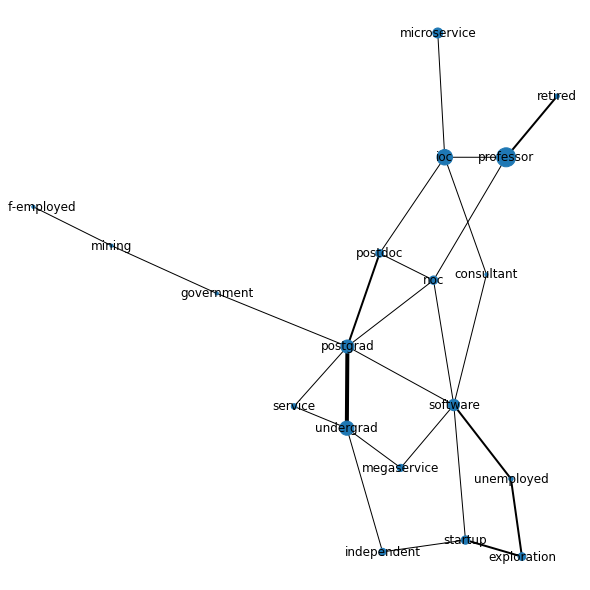

In [23]:
import numpy as np

scale = 10

weights = [G[u][v]['weight'] for u, v in G.edges()]
counts = [scale * G.nodes[u]['count'] for u in G.nodes()]

params = {
    'node_size': counts,
    'with_labels': True,
    'width': weights,
}

pos = nx.spring_layout(G)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
nx.draw(G, pos, **params)

In [24]:
nx.get_node_attributes(G, 'count')

{'independent': 5.0,
 'postdoc': 6.0,
 'noc': 7.0,
 'unemployed': 2.0,
 'undergrad': 20.0,
 'postgrad': 17.0,
 'mining': 1,
 'self-employed': 1,
 'consultant': 1.0,
 'microservice': 10.0,
 'service': 3.0,
 'professor': 36.0,
 'retired': 2,
 'megaservice': 5.0,
 'software': 13.0,
 'exploration': 6.0,
 'startup': 7.0,
 'government': 1,
 'ioc': 24.0}

## Years

In [25]:
def get_years():
    with shelve.open('nodes') as db:
        d = dict(db)

    _ = d.pop('undergrad', None)
    _ = d.pop('retired', None)
    _ = d.pop('unemployed', None)
    _ = d.pop('break', None)
    labels = list(d.keys())
    data = list(d.values())

    return data, labels

In [26]:
def get_lasts(shelf):
    with shelve.open('lasts') as db:
        d = dict(db)
    labels = list(d.keys())
    data = list(d.values())
    return data, labels

In [27]:
import numpy as np
from io import BytesIO
import base64

%matplotlib inline
import matplotlib.pyplot as plt


def plot_bars(data, labels, log=False, title=True, lpos=None):

    data = sorted(data, reverse=True)
    labels = sorted(labels, key=lambda li: data[labels.index(li)], reverse=True)

    y = list(range(len(data)))
    y_min, y_max = y[0]-0.75, y[-1]+0.75

    fig, ax = plt.subplots(figsize=(8, 8))
    bars = ax.barh(y, data, color='orange', align='center', edgecolor='none')
    ax.set_yticks(y)
    if log:
        ax.set_xscale('log')
    ax.set_yticklabels(labels, size=12)
    ax.set_ylim(y_max, y_min)  # Label top-down.
    ax.grid(c='black', alpha=0.15, which='both')
    ax.patch.set_facecolor("white")
    fig.patch.set_facecolor("none")
    
    if title is True:
        t = "{:.2f} person-careers of experience".format(sum(data)/40)
    elif title:
        t = title
    else:
        t = ""
    ax.set_title(t)


    if lpos is None:
        lpos = min(data)
    for i, d in enumerate(data):
        ax.text(lpos, i, "{}".format(int(d)), va='center', size=12)

    plt.tight_layout()

    # Put in memory.
    handle = BytesIO()
    plt.savefig(handle, format='png', facecolor=fig.get_facecolor())
    plt.show()

    # Encode.
    handle.seek(0)
    figdata_png = base64.b64encode(handle.getvalue()).decode('utf8')

    return figdata_png


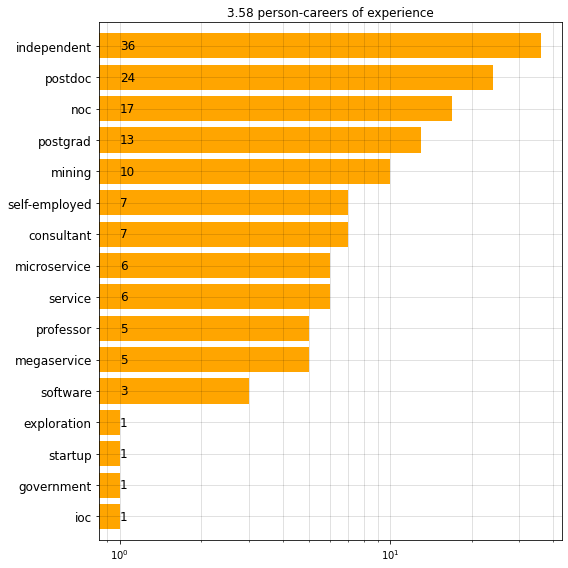

In [28]:
data, labels = get_years()
_ = plot_bars(data, labels, log=True)

## Current thing

In [29]:
_ = plot_bars(*get_data('lasts'), title="Current position")

NameError: name 'get_data' is not defined

## Career lengths

In [30]:
with shelve.open('lens') as db:
    d = dict(db)

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
bins = list(chunks([str(n) for n in range(50)], 5))
bins

[['0', '1', '2', '3', '4'],
 ['5', '6', '7', '8', '9'],
 ['10', '11', '12', '13', '14'],
 ['15', '16', '17', '18', '19'],
 ['20', '21', '22', '23', '24'],
 ['25', '26', '27', '28', '29'],
 ['30', '31', '32', '33', '34'],
 ['35', '36', '37', '38', '39'],
 ['40', '41', '42', '43', '44'],
 ['45', '46', '47', '48', '49']]

In [31]:
d

{'17': 2, '30': 1, '36': 1, '32': 1, '16': 1, '5': 1, '14': 1}

In [32]:
labels = ['<5', '5-9', '10-14', '15-19', '20-24',
        '25-29', '30-34', '35-39', '40-44', '45-49', '>50']

In [33]:
from collections import OrderedDict



In [34]:
data = [0 for l in labels]
for k, v in d.items():
    for idx, row in enumerate(bins):
        if k in row: break
    data[idx] += v
    
OrderedDict((l, d) for l, d in zip(labels, data))

OrderedDict([('<5', 0),
             ('5-9', 1),
             ('10-14', 1),
             ('15-19', 3),
             ('20-24', 0),
             ('25-29', 0),
             ('30-34', 2),
             ('35-39', 1),
             ('40-44', 0),
             ('45-49', 0),
             ('>50', 0)])

In [35]:
data

[0, 1, 1, 3, 0, 0, 2, 1, 0, 0, 0]

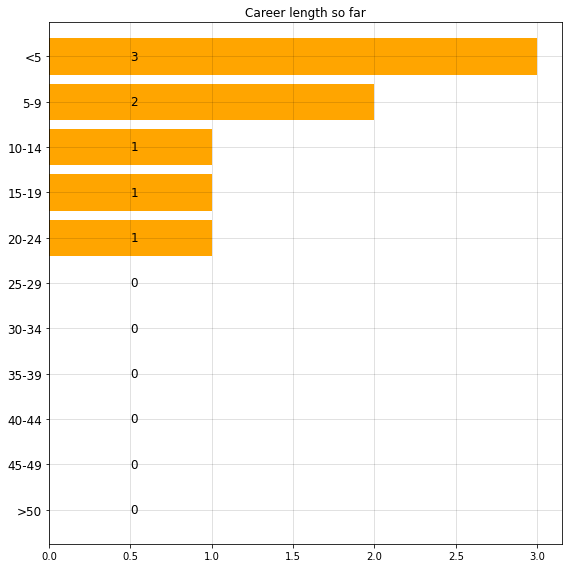

In [36]:
_ = plot_bars(data, labels, title="Career length so far", lpos=0.5)

# Delete the data

In [19]:
# Deletes all the data on the deployed server.
# https://careermap.softwareunderground.org/delete

In [37]:
import requests

requests.delete("https://careermap.softwareunderground.org/delete")

<Response [200]>